# **Projeto de Machine Learning 1 - Sobreviventes no Titanic**
Analistas:
- Raphael Huvos Ribas
- Gustavo Borguetti Daré

Este projeto fará uso de um dataset clássico para ciência de dados, o [Titanic](https://www.kaggle.com/competitions/titanic/data).

Do que se sabe, alguns grupos de pessoas possuíam uma maior chance de sobreviver. Este projeto tem como objetivo tentar prever que tipos de pessoas possuíam esta maior chance e utilizar métricas adequadas para avaliar os modelos utilizados.

In [1]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


## **Pré-processamento**

Antes de iniciar o treino dos modelos, é necessário analisar o dataset e filtrar os dados que serão realmente úteis.

In [2]:
# Criar o DataFrame (df)
import pandas as pd

df = pd.read_csv('train.csv')

In [3]:
# Analisando o dataset em si

df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


O dataset é composto por 12 colunas:
* PassengerId: Identificação do passageiro (inteiro)
* Survived: Valor binário representando se não sobreviveu (0) ou sobreviveu (1)
* Pclass: Classe da passagem (1 = 1a ; 2 = 2a ; 3 = 3a)
* Name: Nome do passageiro
* Sex: Gênero do passageiro
* Age: Idade do passageiro
* SibSp: Número de irmãos/irmãs e esposos/esposas a bordo
* Parch: Número de parentes / crianças a bordo
* Ticket: Número da passagem
* Fate: Tarifa do passageiro (custo da passagem)
* Cabin: Identificação da cabine
* Embarked: Localização de embarque (C = Cherbourg, Q = Queenstown, S = Southampton)

É possível perceber que algumas das colunas apresentam valores ausentes (NaN).

In [4]:
# Analisando valores ausentes

df.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


As colunas que apresentam valores ausentes são: `'Age'`, `'Cabin'` e `'Embarked'`. Para a análise que se pretende realizar neste projeto, destas colunas, a que parece de maior interesse é a `'Age'` (idade), pois pode afetar a probabilidade de sobrevivência.

Os valores que estão faltando de `'Age'` serão preenchidos com a mediana e `'Embarked'` com a moda. Para `'Cabin'`, como os valores são únicos, seria difícil preencher os valores ausentes.


In [5]:
# Preenchendo valores ausentes de 'Age' com a mediana

df['Age'] = df['Age'].fillna(df['Age'].median())

In [6]:
# Preenchendo valores ausentes de 'Embarked' com a moda

df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

Além disso, valores categóricos também serão convertidos

In [7]:
# Mapeando 'Sex' para valores numéricos

df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

In [8]:
# Mapeando 'Embarked' para valores numéricos

df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

Pode-se juntar as colunas `'SibSp'` e `'Parch'` e somar 1 para obter o tamanho da família que estava a bordo do Titanic.

In [9]:
# Somando 'SibSp' e 'Parch', criando nova coluna 'FamilySize'

df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

Por fim, também é possível se livrar de colunas desnecessárias para a análise de sobreviventes, como `'PassengerId'` `'Name'`, `'Ticket'`, `'Cabin'`. `'SibSp'` e `'Parch'` também pois já criou-se uma nova coluna levando em consideração estas duas.

In [10]:
# Deletando estas colunas

df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch'], axis=1)

In [11]:
# Mostrar o dataset após as mudanças

df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize
0,0,3,0,22.0,7.2500,0,2
1,1,1,1,38.0,71.2833,1,2
2,1,3,1,26.0,7.9250,0,1
3,1,1,1,35.0,53.1000,0,2
4,0,3,0,35.0,8.0500,0,1


## **Regressão logística**

Agora que já foi "limpado" o dataset para a análise, é possível começar o treino dos modelos. A iniciar pela regressão logística.

In [12]:
from sklearn.model_selection import train_test_split

# Definir X (característica) e y (variável alvo)

X = df.drop('Survived', axis=1)
y = df['Survived']

# Dividir os dados

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
X.isna().sum()

,0
Pclass,0
Sex,0
Age,0
Fare,0
Embarked,0
FamilySize,0


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Iniciar e treinar o modelo

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [15]:
# Realizar a previsão

y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:,1]

In [16]:
# Avaliar o modelo

print(f'Accuracy Score: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred)}')
print(f'AUC-ROC: {roc_auc_score(y_test, y_pred)}')

Accuracy Score: 0.8100558659217877
Precision: 0.7941176470588235
Recall: 0.7297297297297297
F1 Score: 0.7605633802816901
AUC-ROC: 0.7981981981981983


## **Árvore de Decisão**

In [17]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Aqui utilizamos a mesma divisão de treino e teste feita acima
tree = DecisionTreeClassifier(random_state=42, max_depth=4)
tree.fit(X_train, y_train)

y_pred_tree = tree.predict(X_test)

In [18]:
# Avaliação do modelo de Árvore de Decisão
print(f'Accuracy Score: {accuracy_score(y_test, y_pred_tree)}')
print(f'Precision: {precision_score(y_test, y_pred_tree)}')
print(f'Recall: {recall_score(y_test, y_pred_tree)}')
print(f'F1 Score: {f1_score(y_test, y_pred_tree)}')
print(f'AUC-ROC: {roc_auc_score(y_test, y_pred_tree)}')

Accuracy Score: 0.7988826815642458
Precision: 0.8392857142857143
Recall: 0.6351351351351351
F1 Score: 0.7230769230769231
AUC-ROC: 0.7747104247104247


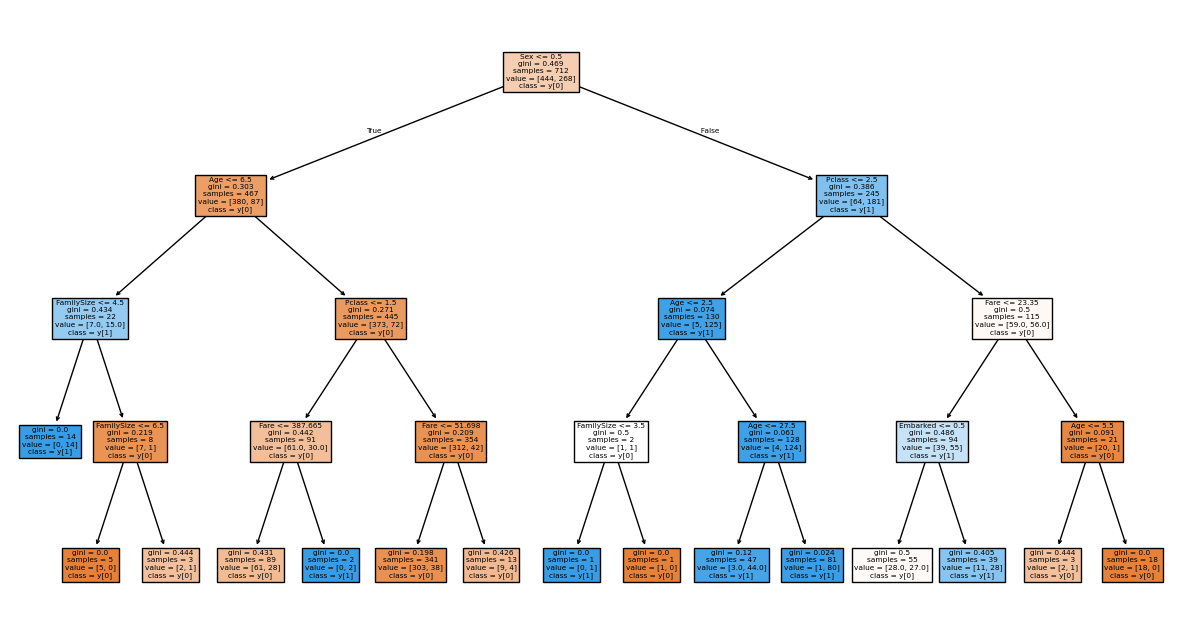

In [19]:
# Plotagem do gráfico de Árvore de Decisão
plt.figure(figsize=(15,8))
plot_tree(tree, filled=True, feature_names=X.columns, class_names=True)
plt.show()